# Pipeline Example

**Example demonstrating multi-query pipeline lineage analysis**

### Imports

In [1]:
from clgraph import Pipeline

# Example: Data pipeline with multiple dependent queries
queries = [
    # Stage 1: Raw data ingestion
    (
        "raw_events",
        """
        CREATE TABLE raw_events AS
        SELECT
            user_id,
            event_type,
            event_timestamp,
            session_id,
            page_url
        FROM source_events
        WHERE event_timestamp >= '2024-01-01'
    """,
    ),
    # Stage 2: Daily aggregation
    (
        "daily_active_users",
        """
        CREATE TABLE daily_active_users AS
        SELECT
            user_id,
            DATE(event_timestamp) as activity_date,
            COUNT(DISTINCT session_id) as session_count,
            COUNT(*) as event_count
        FROM raw_events
        GROUP BY user_id, DATE(event_timestamp)
    """,
    ),
    # Stage 3: User enrichment
    (
        "user_activity_summary",
        """
        CREATE TABLE user_activity_summary AS
        SELECT
            u.name,
            u.email,
            u.signup_date,
            dau.activity_date,
            dau.session_count,
            dau.event_count,
            DATE_DIFF(dau.activity_date, u.signup_date, DAY) as days_since_signup
        FROM users u
        JOIN daily_active_users dau ON u.id = dau.user_id
    """,
    ),
    # Stage 4: Analytics table
    (
        "user_engagement_metrics",
        """
        CREATE TABLE user_engagement_metrics AS
        SELECT
            name,
            email,
            COUNT(*) as active_days,
            SUM(session_count) as total_sessions,
            SUM(event_count) as total_events,
            AVG(session_count) as avg_daily_sessions
        FROM user_activity_summary
        GROUP BY name, email
        HAVING COUNT(*) >= 7
    """,
    ),
]

### Code

In [2]:
print("SQL Pipeline Lineage Example")
print()

# Parse the multi-query pipeline using Pipeline class
print("Building pipeline...")
pipeline = Pipeline(queries, dialect="bigquery")

print(f"✓ Built pipeline with {len(pipeline.table_graph.queries)} queries")
print(f"✓ Found {len(pipeline.columns)} columns")
print()

SQL Pipeline Lineage Example

Building pipeline...
✓ Built pipeline with 4 queries
✓ Found 30 columns



### Example 1: Table execution order

In [3]:
print("1. TABLE EXECUTION ORDER")
execution_order = pipeline.table_graph.get_execution_order()
for i, table in enumerate(execution_order, 1):
    table_node = pipeline.table_graph.tables[str(table)]
    if table_node.is_source:
        print(f"{i}. {table} (source table)")
    else:
        # Find what this table depends on
        query = pipeline.table_graph.queries.get(table_node.created_by)
        if query and query.source_tables:
            print(f"{i}. {table}")
            print(f"   Depends on: {', '.join(sorted(query.source_tables))}")
        else:
            print(f"{i}. {table}")
print()

1. TABLE EXECUTION ORDER
1. source_events (source table)
2. users (source table)
3. raw_events
   Depends on: source_events
4. daily_active_users
   Depends on: raw_events
5. user_activity_summary
   Depends on: daily_active_users, users
6. user_engagement_metrics
   Depends on: user_activity_summary



### Visualize Table Dependencies

Display the table dependency graph showing execution order and data flow between tables.

Table Dependency Graph:


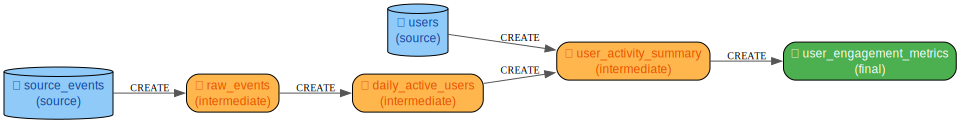

In [4]:
import shutil

from clgraph import visualize_table_dependencies

# Check if graphviz is available
if shutil.which("dot") is None:
    print("⚠️  Graphviz not installed. Install with: brew install graphviz")
    print("   Skipping visualization...")
else:
    # Visualize table-level dependencies
    print("Table Dependency Graph:")
    display(visualize_table_dependencies(pipeline.table_graph))

### Example 2: Trace a column through the pipeline

In [5]:
print("2. BACKWARD LINEAGE (End-to-end column tracing)")
target_col = "user_engagement_metrics.total_events"
print(f"Column: {target_col}")
sources = pipeline.trace_column_backward("user_engagement_metrics", "total_events")
print("Traces back to:")
for source in sources:
    print(f"  → {source.table_name}.{source.column_name}")
print()

2. BACKWARD LINEAGE (End-to-end column tracing)
Column: user_engagement_metrics.total_events
Traces back to:
  → source_events.user_id
  → source_events.event_type
  → source_events.event_timestamp
  → source_events.session_id
  → source_events.page_url



### Example 3: Forward lineage / Impact analysis

In [6]:
print("3. FORWARD LINEAGE (Impact analysis)")
print("Column: source_events.event_timestamp")
impacts = pipeline.trace_column_forward("source_events", "event_timestamp")
print("Used in:")
for impact in impacts:
    print(f"  → {impact.table_name}.{impact.column_name}")
print()

3. FORWARD LINEAGE (Impact analysis)
Column: source_events.event_timestamp
Used in:
  → user_engagement_metrics.active_days
  → user_engagement_metrics.total_events



### Example 4: Show all columns in final table

In [7]:
print("4. FINAL TABLE COLUMNS")
print("Table: user_engagement_metrics")
final_cols = [
    col for col in pipeline.columns.values() if col.table_name == "user_engagement_metrics"
]
for col in sorted(final_cols, key=lambda c: c.column_name):
    print(f"  • {col.column_name}: {col.expression}")
print()

4. FINAL TABLE COLUMNS
Table: user_engagement_metrics
  • active_days: COUNT(*) AS active_days
  • avg_daily_sessions: AVG(session_count) AS avg_daily_sessions
  • email: email
  • name: name
  • total_events: SUM(event_count) AS total_events
  • total_sessions: SUM(session_count) AS total_sessions



### Example 5: Find all PII columns

In [8]:
print("5. COLUMN METADATA EXAMPLE")
# Mark email as PII
if "user_engagement_metrics.email" in pipeline.columns:
    pipeline.columns["user_engagement_metrics.email"].pii = True
    pipeline.columns["user_engagement_metrics.email"].owner = "privacy_team"

# Propagate metadata
pipeline.propagate_all_metadata()

# Find all PII columns
pii_cols = pipeline.get_pii_columns()
print("PII columns in pipeline:")
for col in pii_cols:
    print(f"  ⚠️  {col}")
print()

5. COLUMN METADATA EXAMPLE
📊 Pass 1: Propagating metadata backward from 22 output columns...
📊 Pass 2: Propagating metadata forward for 22 columns...
✅ Done! Propagated metadata for 22 columns
PII columns in pipeline:
  ⚠️  ColumnNode('user_engagement_metrics.email')



### Example 6: Access graph objects directly

In [9]:
print("6. GRAPH OBJECTS")
print("Pipeline contains two graph structures:\n")

# Table-level graph
print("  pipeline.table_graph (TableDependencyGraph):")
print(f"    - tables: {len(pipeline.table_graph.tables)} tables")
print(f"    - queries: {len(pipeline.table_graph.queries)} queries")
print("    - Methods: get_source_tables(), get_final_tables(),")
print("               get_dependencies(table), get_downstream(table)")
print()

# Column-level graph
print("  pipeline.column_graph (PipelineLineageGraph):")
print(f"    - columns: {len(pipeline.column_graph.columns)} columns")
print(f"    - edges: {len(pipeline.column_graph.edges)} edges")
print("    - Methods: get_source_columns(), get_final_columns(),")
print("               get_upstream(column), get_downstream(column)")
print()

6. GRAPH OBJECTS
Pipeline contains two graph structures:

  pipeline.table_graph (TableDependencyGraph):
    - tables: 6 tables
    - queries: 4 queries
    - Methods: get_source_tables(), get_final_tables(),
               get_dependencies(table), get_downstream(table)

  pipeline.column_graph (PipelineLineageGraph):
    - columns: 30 columns
    - edges: 33 edges
    - Methods: get_source_columns(), get_final_columns(),
               get_upstream(column), get_downstream(column)



### Example 7: Column graph methods

In [10]:
print("7. COLUMN GRAPH METHODS")

# Get source columns (no incoming edges)
source_cols = pipeline.column_graph.get_source_columns()
print(f"  Source columns (no incoming edges): {len(source_cols)}")
for col in source_cols[:5]:
    print(f"    📥 {col.full_name}")
if len(source_cols) > 5:
    print(f"    ... and {len(source_cols) - 5} more")
print()

# Get final columns (no outgoing edges)
final_cols = pipeline.column_graph.get_final_columns()
print(f"  Final columns (no outgoing edges): {len(final_cols)}")
for col in final_cols[:5]:
    print(f"    📤 {col.full_name}")
if len(final_cols) > 5:
    print(f"    ... and {len(final_cols) - 5} more")
print()

# Get upstream for a specific column
target = "user_engagement_metrics.total_events"
if target in pipeline.columns:
    upstream = pipeline.column_graph.get_upstream(target)
    print(f"  Direct upstream of {target}:")
    for col in upstream[:5]:
        print(f"    ← {col.full_name}")
print()

print("Pipeline analysis complete!")

7. COLUMN GRAPH METHODS
  Source columns (no incoming edges): 8
    📥 source_events.user_id
    📥 source_events.event_type
    📥 source_events.event_timestamp
    📥 source_events.session_id
    📥 source_events.page_url
    ... and 3 more

  Final columns (no outgoing edges): 7
    📤 daily_active_users.user_id
    📤 user_engagement_metrics.name
    📤 user_engagement_metrics.email
    📤 user_engagement_metrics.active_days
    📤 user_engagement_metrics.total_sessions
    ... and 2 more

  Direct upstream of user_engagement_metrics.total_events:
    ← user_activity_summary.event_count

Pipeline analysis complete!


### Visualize Column Lineage

Display the complete column-level lineage showing how data flows through the entire pipeline.

Full Pipeline Column Lineage:


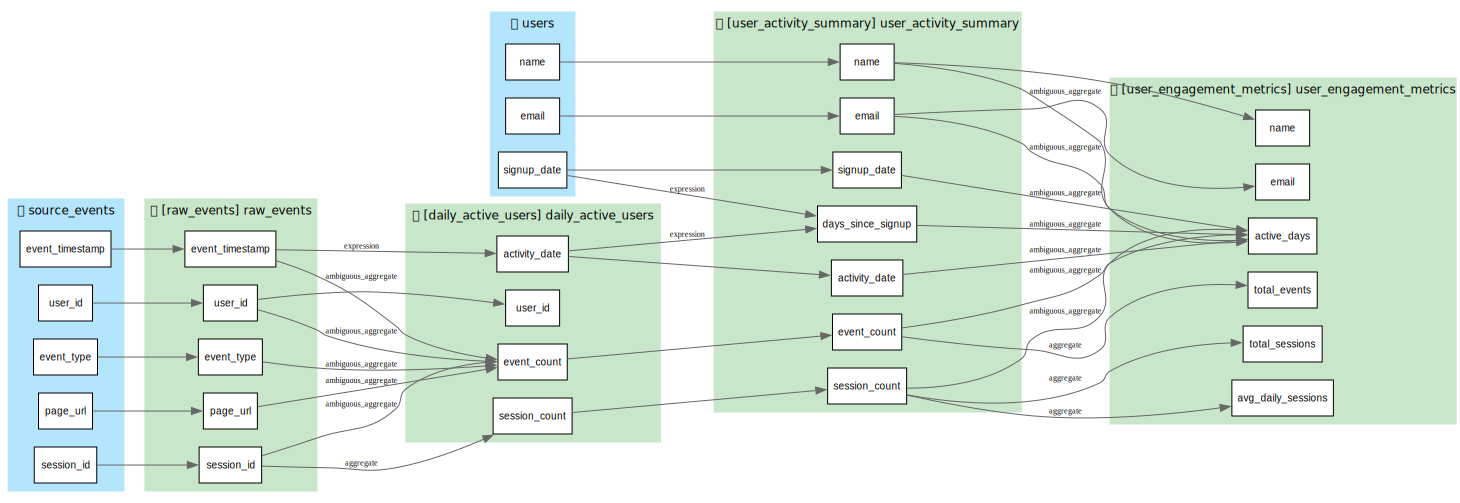

In [11]:
from clgraph import visualize_pipeline_lineage

# Visualize the full pipeline column lineage
if shutil.which("dot") is not None:
    print("Full Pipeline Column Lineage:")
    display(visualize_pipeline_lineage(pipeline))

Simplified Lineage (Source → Final tables only):


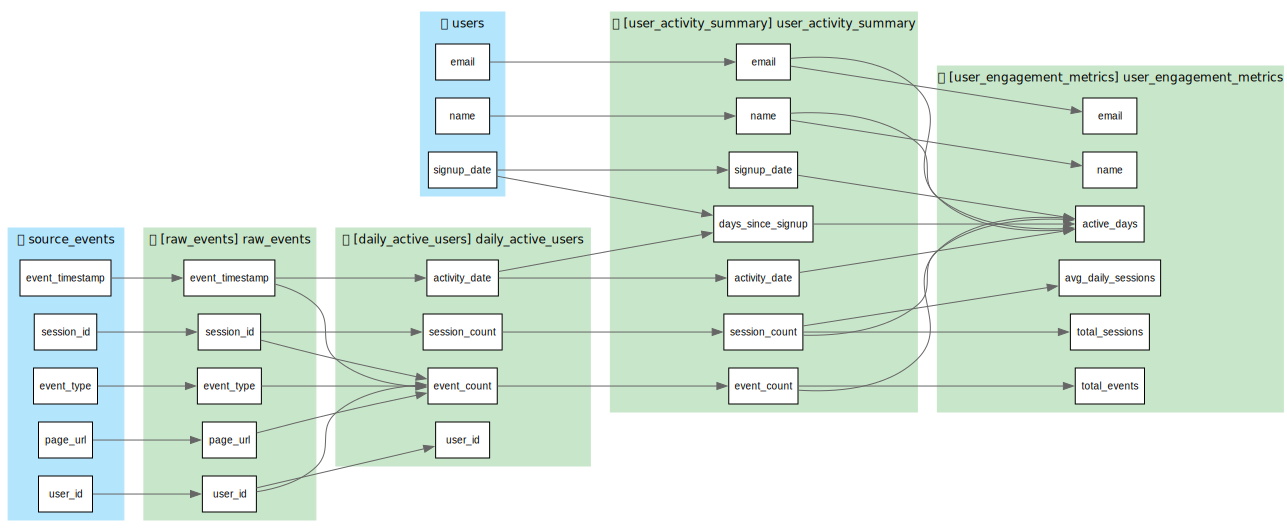

In [12]:
# Simplified view: Source tables → Final tables only
if shutil.which("dot") is not None:
    print("Simplified Lineage (Source → Final tables only):")
    display(visualize_pipeline_lineage(pipeline.column_graph.to_simplified()))